In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset"

import os
print("📂 Current directory:", os.getcwd())
!apt install tree -y
!tree -L 2 -a --dirsfirst

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset
📂 Current directory: /content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
.
├── data
│   └── MNIST
├── MVP_Model
│   ├── cGAN_mvp
│   ├── GAN_mvp
│   └── VAE_mvp
└── Notebook
    ├── DCGAN & cGAN.ipynb
    ├── GAN_Train.ipynb
    └── VAE.ipynb

7 directories, 3 files


In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch, torch.nn as nn
import os
import sys

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# I. Data Preparation

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# II. Model

## 1. Definition

In [5]:
class Generator(nn.Module):
    """
    Aim: Latent vector [batch_size, latent_dim] -> [batch_size, 1, 28, 28]
    """
    def __init__(self, latent_dim, n_class):
        super(Generator, self).__init__()

        self.n_class = n_class
        self.latent_dim = latent_dim

        self.label_emb = nn.Embedding(n_class, 50)
        self.label_dense = nn.Linear(50, 7*7)

        self.latent_dense = nn.Linear(self.latent_dim, 32*7*7)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        # Conv2DTranspose layers
        self.deconv1 = nn.ConvTranspose2d(32+1, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)

        self.conv = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, z, labels):
        """
        Input: z: [batch_size, latent_dim]
               labels: [batch_size]
        Output: [batch_size, 1, 28, 28]
        """
        label_emb = self.label_emb(labels)                              # [batch_size, 50]
        label_dense = self.label_dense(label_emb)                       # [batch_size, 7*7]
        label_dense = label_dense.view(-1, 1, 7, 7)

        latent_dense = self.latent_dense(z)                             # [batch_size, 32*7*7]
        latent_dense = latent_dense.view(-1, 32, 7, 7)

        latent_dense = torch.cat([latent_dense, label_dense], dim=1)    # [batch_size, 33, 7, 7]
        latent_dense = self.leaky(latent_dense)

        out = self.deconv1(latent_dense)
        # H_in = 7, K = 4, S = 2, P = 1, D = 1 (default), OP = 0 (default)
        # -> H_out = (H_in​−1)⋅S ​− 2⋅P ​+ D​⋅(K​−1)+ OP ​+ 1 = (7-1).2 - 2.1 + 1(4-1) + 0 + 1 = 14

        out = self.deconv2(out)
        # Similarly, H_out = 28, out: [batch_size, 32, 28, 28]

        out = self.tanh(self.conv(out))
        # out: [batch_size, 1, 28, 28]
        return out

class Discriminator(nn.Module):
    def __init__(self, img_size, n_class) -> None:
        super().__init__()
        self.img_size = img_size
        self.n_class = n_class

        # Embedding cho label
        self.label_emb = nn.Embedding(n_class, 50)
        self.label_dense = nn.Linear(50, img_size*img_size)

        # Conv2d layer: H_out = (H_in + 2P - K)/2 + 1
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        # Fully connected
        self.flatten = nn.Flatten()
        conv_output_size = img_size//4
        self.fc = nn.Linear(32 * conv_output_size * conv_output_size, 1)
        self.drop = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, labels):
        """
        Input: images: [batch_size, 1, 28, 28]
               labels: [batch_size]
        Output: [batch_size, 1]
        """

        # Label embedding
        label_emb = self.label_emb(labels)                                      # [batch, 50]
        label_dense = self.label_dense(label_emb)                               # [batch, img_size*img_size]
        label_reshaped = label_dense.view(-1, 1, self.img_size, self.img_size)  # [batch, 1, H, W]

        out = torch.cat([images, label_reshaped], dim=1)                        # [batch, image_channel+1, H, W]
        out = self.conv1(out)                                                   # [batch, 32, H/2, W/2]
        out = self.leaky(self.conv2(out))                                       # [batch, 32, H/4, W/4]

        out = self.flatten(out)                                                 # [batch, 32*H/4*W/4]
        out = self.drop(out)
        out = self.fc(out)                                                      # [batch, 1]
        out = self.sigmoid(out)

        return out

def train_cGAN(gen, disc, dataloader, optimizer_G, optimizer_D, criterion, z_dim, device='cpu'):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0

    gen = gen.to(device)
    disc = disc.to(device)

    gen.train()
    disc.train()

    for batch_idx, (real_imgs, real_labels) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        real_class = real_labels.to(device)

        z = torch.randn(real_imgs.shape[0], z_dim).to(device)
        gen_imgs = gen(z, real_class)

        real_labels = torch.ones((real_imgs.size(0), 1), device=device)
        fake_labels = torch.zeros((real_imgs.size(0), 1), device=device)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()

        real_loss = criterion(disc(real_imgs, real_class), real_labels)
        real_loss.backward()
        optimizer_D.step()

        fake_loss = criterion(disc(gen_imgs.detach(), real_class), fake_labels)
        fake_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        fake_outputs = disc(gen_imgs, real_class)
        gen_loss = criterion(fake_outputs, real_labels)
        gen_loss.backward()
        optimizer_G.step()

        epoch_loss_D += (real_loss.item() + fake_loss.item()) * real_imgs.size(0)
        epoch_loss_G += gen_loss.item() * real_imgs.size(0)

    epoch_loss_D /= len(dataloader.dataset)
    epoch_loss_G /= len(dataloader.dataset)

    return epoch_loss_D, epoch_loss_G

## 2. Training

In [6]:
gen         = Generator(100,10)
disc        = Discriminator(28,10)
dataloader  = train_loader
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion   = nn.BCELoss()
z_dim       = 100
device      = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
save_dir = "./MVP_Model/cGAN_mvp"
os.makedirs(save_dir, exist_ok=True)

In [8]:
n_epochs = 50
loss_D_list, loss_G_list = [], []
best_loss_G = float('-inf')

for epoch in range(n_epochs):
    epoch_loss_D, epoch_loss_G = train_cGAN(gen         = gen,
                                            disc        = disc,
                                            dataloader  = train_loader,
                                            optimizer_G = optimizer_G,
                                            optimizer_D = optimizer_D,
                                            criterion   = criterion,
                                            z_dim       = z_dim,
                                            device      = device,
                                            )
    loss_D_list.append(epoch_loss_D)
    loss_G_list.append(epoch_loss_G)

    print(f"Epoch [{epoch+1}/{n_epochs}] Completed | Avg Loss D: {epoch_loss_D:.4f} | Avg Loss G: {epoch_loss_G:.4f}")

    if epoch_loss_G > best_loss_G:
        best_loss_G = epoch_loss_G
        torch.save(gen.state_dict(), os.path.join(save_dir, 'best_gen.pth'))
        torch.save(disc.state_dict(), os.path.join(save_dir, 'best_disc.pth'))

Epoch [1/50] Completed | Avg Loss D: 1.1649 | Avg Loss G: 1.0356
Epoch [2/50] Completed | Avg Loss D: 1.4356 | Avg Loss G: 0.4989
Epoch [3/50] Completed | Avg Loss D: 1.3672 | Avg Loss G: 0.5333
Epoch [4/50] Completed | Avg Loss D: 1.2587 | Avg Loss G: 0.6210
Epoch [5/50] Completed | Avg Loss D: 1.0756 | Avg Loss G: 0.8415
Epoch [6/50] Completed | Avg Loss D: 0.9279 | Avg Loss G: 1.1134
Epoch [7/50] Completed | Avg Loss D: 0.8328 | Avg Loss G: 1.3519
Epoch [8/50] Completed | Avg Loss D: 0.7607 | Avg Loss G: 1.5705
Epoch [9/50] Completed | Avg Loss D: 0.7441 | Avg Loss G: 1.6472
Epoch [10/50] Completed | Avg Loss D: 0.7048 | Avg Loss G: 1.7939
Epoch [11/50] Completed | Avg Loss D: 0.6968 | Avg Loss G: 1.8344
Epoch [12/50] Completed | Avg Loss D: 0.6458 | Avg Loss G: 2.0251
Epoch [13/50] Completed | Avg Loss D: 0.5938 | Avg Loss G: 2.2019
Epoch [14/50] Completed | Avg Loss D: 0.6090 | Avg Loss G: 2.2425
Epoch [15/50] Completed | Avg Loss D: 0.6543 | Avg Loss G: 2.1447
Epoch [16/50] Compl

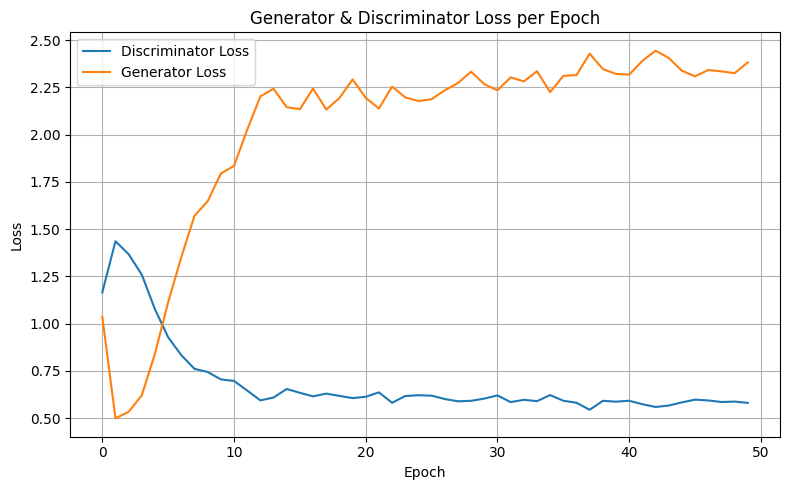

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.plot(loss_D_list, label="Discriminator Loss")
axs.plot(loss_G_list, label="Generator Loss")

axs.set_title("Generator & Discriminator Loss per Epoch")
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()
plt.close(fig)

# III. Testing

In [11]:
gen_test      = Generator(100,10)
disc_test     = Discriminator(28,10)

save_dir = "./MVP_Model/cGAN_mvp"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gen_state = torch.load(os.path.join(save_dir, 'best_gen.pth'))
disc_state = torch.load(os.path.join(save_dir, 'best_disc.pth'))

gen_test.load_state_dict(gen_state)
disc_test.load_state_dict(disc_state)

gen_test.to(device)
disc_test.to(device)

gen_test.eval()
disc_test.eval()

Discriminator(
  (label_emb): Embedding(10, 50)
  (label_dense): Linear(in_features=50, out_features=784, bias=True)
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (leaky): LeakyReLU(negative_slope=0.2, inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1568, out_features=1, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
)

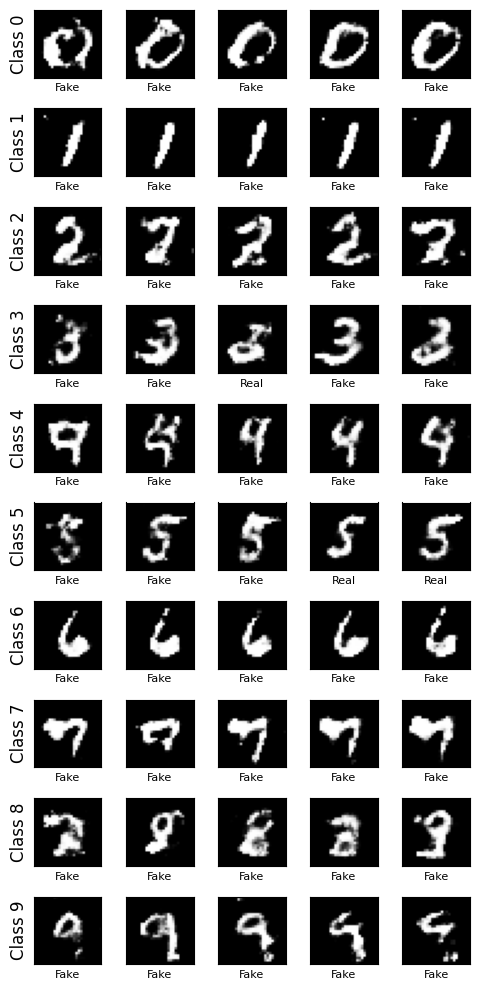

In [15]:
import torch
import matplotlib.pyplot as plt

num_classes = 10
num_samples_each_class = 5
latent_dim = 100


fig, axs = plt.subplots(num_classes, num_samples_each_class, figsize=(5, 10))

with torch.no_grad():
    for i in range(num_classes):
        z = torch.randn(num_samples_each_class, latent_dim, device=device)
        labels = torch.full((num_samples_each_class,), i, device=device, dtype=torch.long)

        generated_images = gen_test(z, labels)  # [B,1,28,28]

        # Output of discriminator
        disc_outputs = disc_test(generated_images, labels)  # [B,1] hoặc [B]
        disc_preds = (disc_outputs > 0.5).cpu().numpy()

        for j in range(num_samples_each_class):
            img = generated_images[j].cpu().squeeze()  # [28,28]
            img = img * 0.5 + 0.5  # scale về [0,1]

            pred = "Real" if disc_preds[j] else "Fake"

            ax = axs[i, j]
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

            if j == 0:
                ax.set_ylabel(f"Class {i}", fontsize=12)

            ax.set_xlabel(pred, fontsize=8)

plt.tight_layout()
plt.show()
